In [13]:
import sys
print(sys.path)
import seaborn as sns
sns.set()

['', '/opt/conda/lib/python36.zip', '/opt/conda/lib/python3.6', '/opt/conda/lib/python3.6/lib-dynload', '/opt/conda/lib/python3.6/site-packages', '/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg', '/opt/conda/lib/python3.6/site-packages/IPython/extensions', '/home/yukimiki/.ipython', '/tmp/fastai/old']


In [2]:
sys.path.append("/tmp/fastai/old")

In [3]:
import fastai

In [4]:
from fastai.conv_learner import *

In [5]:
from fastai.dataset import *

In [6]:
from datetime import datetime
import pandas as pd
import numpy as np
np.random.seed(seed=32)
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import scipy.optimize as opt
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
#from torchvision.transforms import RandomHorizontalFlip, RandomVerticalFlip
from tensorboard_cb import TensorboardLogger
import torch
torch.manual_seed(7)
torch.cuda.manual_seed_all(7)
import utils_pytorch

In [7]:
nw = 20   #number of workers for data loader

In [8]:
train_names = list({f[:36] for f in os.listdir(utils_pytorch.TRAIN)})
test_names = list({f[:36] for f in os.listdir(utils_pytorch.TEST)})
# tr_n, val_n = train_test_split(train_names, test_size=0.1, random_state=42)

data_info = pd.read_csv(utils_pytorch.LABELS)
tr_n, val_n = train_test_split(data_info, test_size = 0.1, 
                 stratify = data_info['Target'].map(lambda x: x[:3] if '27' not in x else '0'), random_state=42)
tr_n = tr_n['Id'].tolist()
val_n = val_n['Id'].tolist()

In [9]:
def get_data(sz,bs):
    #data augmentation
    aug_tfms = [RandomRotate(45, tfm_y=TfmType.NO),
                RandomFlip(),
                RandomDihedral(tfm_y=TfmType.NO),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.NO)]
    #mean and std in of each channel in the train set
    #stats = A([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])
    #stats = A([0.0868 , 0.05959, 0.06522, 0.08891], [0.13044, 0.09792, 0.14862, 0.13281])
    stats = A([0.0804419, 0.05262986, 0.05474701, 0.08270896], [0.13000701, 0.08796628, 0.1386317, 0.12718021])
    tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, 
                aug_tfms=aug_tfms)
    ds = ImageData.get_ds(utils_pytorch.pdFilesDataset, (tr_n[:-(len(tr_n)%bs)],utils_pytorch.TRAIN), 
                (val_n,utils_pytorch.TRAIN), tfms, test=(test_names,utils_pytorch.TEST))
    md = ImageData(utils_pytorch.PATH, ds, bs, num_workers=nw, classes=None)
    return md

In [10]:
arch = resnet34 #specify target architecture

sz = 512 #image size
bs = 64  #batch size

dir_name = datetime.strftime(datetime.now(), '%Y%m%d%H%M%S')
print(dir_name)
dir_path = os.path.join('test', dir_name)
best_model_path = dir_name + 'best_resnet50'


md = get_data(sz,bs)
learner = utils_pytorch.ConvLearner.pretrained(arch, md, ps=0.5) #dropout 50%
#pretrained_model_name = '20181202230854_size256_B64_lr0.001_resnet50_best_resnet' # 299
pretrained_model_name = '20181206004817_size256_B64_lr0.01_resnet34_best_resnet' # 512
learner.load(pretrained_model_name)
learner.set_data(md)

learner.opt_fn = optim.Adam
learner.clip = 1.0 #gradient clipping
learner.crit = utils_pytorch.FocalLoss()
learner.metrics = [utils_pytorch.acc, utils_pytorch.f1_torch]
tb_logger = TensorboardLogger(learner.model, md, dir_path, metrics_names=['acc', 'f1'])
#save_best_model = SaveBestModel(model=learner.model)

20181206071803


In [11]:
#learner.summary

 72%|███████▏  | 315/436 [16:03<01:32,  1.31it/s, loss=2.94]

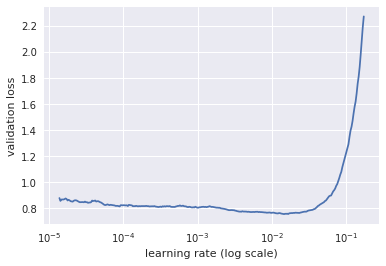

In [12]:
#learner.lr_find(start_lr=1e-6, end_lr=1e-2)
learner.lr_find()
learner.sched.plot()

In [ ]:
lr = 1e-4
learner.fit(lr,1, best_save_name=best_model_path, callbacks=[tb_logger])

In [ ]:
learner.sched.plot_loss()

In [ ]:
learner.unfreeze()
lrs=np.array([lr/10,lr/3,lr])

In [ ]:
learner.fit(lrs/4,4,cycle_len=2,use_clr=(10,20), best_save_name=best_model_path, callbacks=[tb_logger])

In [ ]:
learner.sched.plot_loss()

In [ ]:
learner.sched.plot_lr()

In [ ]:
learner.fit(lrs/4,2,cycle_len=4,use_clr=(10,20), best_save_name=best_model_path, callbacks=[tb_logger])

In [ ]:
learner.sched.plot_loss()

In [ ]:
learner.sched.plot_lr()

In [ ]:
learner.fit(lrs/16,1,cycle_len=8,use_clr=(5,20), best_save_name=best_model_path, callbacks=[tb_logger])

In [ ]:
learner.sched.plot_loss()

In [ ]:
learner.save('ResNet34_256_1')

In [ ]:
learner.load(best_model_path)

In [ ]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

preds,y = learner.TTA(n_aug=16)
preds = np.stack(preds, axis=-1)
preds = sigmoid_np(preds)
pred = preds.max(axis=-1)

In [ ]:
def F1_soft(preds,targs,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = 0.5*np.ones(len(utils_pytorch.name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [ ]:
th = fit_val(pred,y)
th[th<0.1] = 0.1
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 macro (th = 0.5): ',f1_score(y, pred>0.5, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

In [ ]:
print('Fractions: ',(pred > th).mean(axis=0))
print('Fractions (true): ',(y > th).mean(axis=0))

In [ ]:
preds_t,y_t = learner.TTA(n_aug=16,is_test=True)
preds_t = np.stack(preds_t, axis=-1)
preds_t = sigmoid_np(preds_t)
pred_t = preds_t.max(axis=-1) #max works better for F1 macro score

In [ ]:
def save_pred(pred, th=0.5, fname='protein_classification.csv'):
    pred_list = []
    for line in pred:
        s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
        pred_list.append(s)
        
    sample_df = pd.read_csv(utils_pytorch.SAMPLE)
    sample_list = list(sample_df.Id)
    pred_dic = dict((key, value) for (key, value) 
                in zip(learner.data.test_ds.fnames,pred_list))
    pred_list_cor = [pred_dic[id] for id in sample_list]
    df = pd.DataFrame({'Id':sample_list,'Predicted':pred_list_cor})
    df.to_csv(os.path.join('logs', dir_path, fname), header=True, index=False)

In [ ]:
th_t = np.array([0.565,0.39,0.55,0.345,0.33,0.39,0.33,0.45,0.38,0.39,
               0.34,0.42,0.31,0.38,0.49,0.50,0.38,0.43,0.46,0.40,
               0.39,0.505,0.37,0.47,0.41,0.545,0.32,0.1])
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t)

In [ ]:
print('Thresholds: ',th_t)
print('F1 macro: ',f1_score(y, pred>th_t, average='macro'))
print('F1 macro (th = 0.5): ',f1_score(y, pred>0.5, average='macro'))
print('F1 micro: ',f1_score(y, pred>th_t, average='micro'))

In [ ]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]
# I replaced 0 by 0.01 since there may be a rounding error leading to 0

In [ ]:
def Count_soft(preds,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = 0.5*np.ones(len(utils_pytorch.name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [ ]:
th_t = fit_test(pred_t,lb_prob)
th_t[th_t<0.1] = 0.1
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.5): ',(pred_t > 0.5).mean(axis=0))

In [ ]:
print('Thresholds: ',th_t)
print('F1 macro: ',f1_score(y, pred>th_t, average='macro'))
print('F1 macro (th = 0.5): ',f1_score(y, pred>0.5, average='macro'))
print('F1 micro: ',f1_score(y, pred>th_t, average='micro'))

In [ ]:
save_pred(pred_t,th_t,'protein_classification_f.csv')

In [ ]:
save_pred(pred_t,th,'protein_classification_v.csv')
save_pred(pred_t,0.5,'protein_classification_05.csv')

In [ ]:
class_list = [8,9,10,15,20,24,27]
for i in class_list:
    th_t[i] = th[i]
save_pred(pred_t,th_t,'protein_classification_c.csv')

In [ ]:
labels = pd.read_csv(utils_pytorch.LABELS).set_index('Id')
label_count = np.zeros(len(utils_pytorch.name_label_dict))
for label in labels['Target']:
    l = [int(i) for i in label.split()]
    label_count += np.eye(len(utils_pytorch.name_label_dict))[l].sum(axis=0)
label_fraction = label_count.astype(np.float)/len(labels)
label_count, label_fraction

In [ ]:
th_t = fit_test(pred_t,label_fraction)
th_t[th_t<0.05] = 0.05
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t,'protein_classification_t.csv')

In [ ]:
print('Thresholds: ',th_t)
print('F1 macro: ',f1_score(y, pred>th_t, average='macro'))
print('F1 macro (th = 0.5): ',f1_score(y, pred>0.5, average='macro'))
print('F1 micro: ',f1_score(y, pred>th_t, average='micro'))